# **Sentiment Analysis on Masks**
<p align="center">
  <img width="460" height="300" src="https://www.unicef.org/indonesia/sites/unicef.org.indonesia/files/styles/hero_mobile/public/UNI360179.jpg?itok=Ammj8wo5">
</p>

It has been more than a year, the earth, especially Indonesia, is not doing well. The COVID-19 outbreak has yet to be stopped. Not getting better, in fact recently a new variant of covid-19 was discovered with more spread and risk than the previous variant. One of the ways we can protect ourselves from the spread of the Covid-19 virus is by wearing a mask. It is undeniable that maybe some people are starting to feel uncomfortable using masks or are even more aware of using masks. Therefore, in this notebook, I want to do an analysis to see how people's sentiments towards the use of masks are, whether positive, negative or maybe neutral

## **Install and Import Library**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install snscrape

In [ ]:
!pip install Sastrawi

In [ ]:
!pip install google_trans_new

In [ ]:
import pandas as pd
import numpy as np
import csv
import snscrape.modules.twitter as sntwitter
import itertools
import seaborn as sn
import matplotlib.pyplot as plt
import nltk
import re
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob
from google_trans_new import google_translator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## **Scrapping**

In [6]:
df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
   'masker').get_items(), 100))[['username', 'date', 'content']]

## **Exploratory Data Analysis**

In [ ]:
df.head()

,username,date,content
0,nctjaemir,2021-06-29 04:10:37+00:00,@kyuhee___ Pake masker dong.
1,rmcherries,2021-06-29 04:10:34+00:00,Gw bela2in pake double masker tp masih aja ada...
2,TabananPolres,2021-06-29 04:10:22+00:00,Personil Bhabinkamtibmas Desa Baturiti Polsek ...
3,LonelyRoadBiker,2021-06-29 04:10:12+00:00,"Itu baru planning ke dpn, coba lu baca\n\nSkrg..."
4,banxnamilkth,2021-06-29 04:10:02+00:00,"@rahasiarif kak arif juga stay safe yah, kalo ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   username  100 non-null    object             
 1   date      100 non-null    datetime64[ns, UTC]
 2   content   100 non-null    object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 2.5+ KB


In [ ]:
df['content']

0                          @kyuhee___ Pake masker dong.
1     Gw bela2in pake double masker tp masih aja ada...
2     Personil Bhabinkamtibmas Desa Baturiti Polsek ...
3     Itu baru planning ke dpn, coba lu baca\n\nSkrg...
4     @rahasiarif kak arif juga stay safe yah, kalo ...
                            ...                        
95    @Larasati_Nikken Benerr. tp mau gmn lg ya samp...
96    pake masker medis trus di dobel di luar perasa...
97                           Sesek juga pake dua masker
98    @Askrlfess Gapapa. Asal jangan kontak langsung...
99    5M: harus tetap\nMenjaga jarak,\nMencuci tanga...
Name: content, Length: 100, dtype: object

In [ ]:
df = df.drop(columns=['username', 'date'])

In [ ]:
df.head()

,content
0,@kyuhee___ Pake masker dong.
1,Gw bela2in pake double masker tp masih aja ada...
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg..."
4,"@rahasiarif kak arif juga stay safe yah, kalo ..."


In [ ]:
df.content=df.content.astype(str)

In [ ]:
df.to_csv('/content/drive/MyDrive/final-project/dataset/dataset_masker.csv', index=None)

## **Data Preprocessing**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/final-project/dataset/dataset_masker.csv')

In [ ]:
def clean_text(tweet):
    tweet = tweet.lower() # text lowercase
    tweet = re.sub('@[^\s]+', '', tweet) # remove usernames
    tweet = re.sub('\[.*?\]', '', tweet) # remove square brackets
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # remove URLs
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) # remove punctuation
    tweet = re.sub('\w*\d\w*', '', tweet) 
    tweet = re.sub('[‘’“”…]', '', tweet)
    tweet = re.sub('\n', '', tweet)
    return tweet

tweet = lambda x: clean_text(x)

In [ ]:
df['clean1'] = pd.DataFrame(df.content.apply(tweet))
df.head()

,content,clean1
0,@kyuhee___ Pake masker dong.,pake masker dong
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...


In [ ]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('indonesian'), additional)

df['clean2'] = (df['clean1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (swords)])))
df.head()

,content,clean1,clean2
0,@kyuhee___ Pake masker dong.,pake masker dong,pake masker
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...,gw pake double masker tp aja yg gapake masker ...
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...,planning dpn coba lu bacaskrg singapore sdg wa...
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...,kak arif stay safe yah kalo kluar jgn lupa pak...


In [ ]:
text = df['clean2']

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
list_hasil = text
output = [(stemmer.stem(token)) for token in list_hasil]

In [ ]:
df['clean3'] = output

In [ ]:
df.dropna()

,content,clean1,clean2,clean3
0,@kyuhee___ Pake masker dong.,pake masker dong,pake masker,pake masker
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...,gw pake double masker tp aja yg gapake masker ...,gw pake double masker tp aja yg gapake masker ...
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...,planning dpn coba lu bacaskrg singapore sdg wa...,planning dpn coba lu bacaskrg singapore sdg wa...
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...,kak arif stay safe yah kalo kluar jgn lupa pak...,kak arif stay safe yah kalo kluar jgn lupa pak...
...,...,...,...,...
95,@Larasati_Nikken Benerr. tp mau gmn lg ya samp...,benerr tp mau gmn lg ya sampe skrg aja virusn...,benerr tp gmn lg ya sampe skrg aja virusnya g ...,benerr tp gmn lg ya sampe skrg aja virus g aja...
96,pake masker medis trus di dobel di luar perasa...,pake masker medis trus di dobel di luar perasa...,pake masker medis trus dobel perasaan engap ma...,pake masker medis trus dobel asa engap masker ...
97,Sesek juga pake dua masker,sesek juga pake dua masker,sesek pake masker,sek pake masker
98,@Askrlfess Gapapa. Asal jangan kontak langsung...,gapapa asal jangan kontak langsung namanya is...,gapapa kontak langsung namanya isolasi kalo te...,gapapa kontak langsung nama isolasi kalo paksa...


In [ ]:
df['tokens'] = pd.DataFrame(df['clean3'].apply(nltk.word_tokenize))
df

,content,clean1,clean2,clean3,tokens
0,@kyuhee___ Pake masker dong.,pake masker dong,pake masker,pake masker,"[pake, masker]"
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...,gw pake double masker tp aja yg gapake masker ...,gw pake double masker tp aja yg gapake masker ...,"[gw, pake, double, masker, tp, aja, yg, gapake..."
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,"[personil, bhabinkamtibmas, desa, baturiti, po..."
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...,planning dpn coba lu bacaskrg singapore sdg wa...,planning dpn coba lu bacaskrg singapore sdg wa...,"[planning, dpn, coba, lu, bacaskrg, singapore,..."
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...,kak arif stay safe yah kalo kluar jgn lupa pak...,kak arif stay safe yah kalo kluar jgn lupa pak...,"[kak, arif, stay, safe, yah, kalo, kluar, jgn,..."
...,...,...,...,...,...
95,@Larasati_Nikken Benerr. tp mau gmn lg ya samp...,benerr tp mau gmn lg ya sampe skrg aja virusn...,benerr tp gmn lg ya sampe skrg aja virusnya g ...,benerr tp gmn lg ya sampe skrg aja virus g aja...,"[benerr, tp, gmn, lg, ya, sampe, skrg, aja, vi..."
96,pake masker medis trus di dobel di luar perasa...,pake masker medis trus di dobel di luar perasa...,pake masker medis trus dobel perasaan engap ma...,pake masker medis trus dobel asa engap masker ...,"[pake, masker, medis, trus, dobel, asa, engap,..."
97,Sesek juga pake dua masker,sesek juga pake dua masker,sesek pake masker,sek pake masker,"[sek, pake, masker]"
98,@Askrlfess Gapapa. Asal jangan kontak langsung...,gapapa asal jangan kontak langsung namanya is...,gapapa kontak langsung namanya isolasi kalo te...,gapapa kontak langsung nama isolasi kalo paksa...,"[gapapa, kontak, langsung, nama, isolasi, kalo..."


In [ ]:
translator = google_translator()  

In [ ]:
def translate_column(text, target_language):
    return translator.translate(text, lang_tgt=target_language)

In [ ]:
df['clean_english'] = df['clean3'].apply(lambda x: translate_column(x, 'en'))

In [ ]:
df.head()

,content,clean1,clean2,clean3,tokens,clean_english
0,@kyuhee___ Pake masker dong.,pake masker dong,pake masker,pake masker,"[pake, masker]",Use a mask
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...,gw pake double masker tp aja yg gapake masker ...,gw pake double masker tp aja yg gapake masker ...,"[gw, pake, double, masker, tp, aja, yg, gapake...",I use a double mask but just what gapake mask ...
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,"[personil, bhabinkamtibmas, desa, baturiti, po...",Personnel Bhabinkamtibmas Baturiti Village Pol...
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...,planning dpn coba lu bacaskrg singapore sdg wa...,planning dpn coba lu bacaskrg singapore sdg wa...,"[planning, dpn, coba, lu, bacaskrg, singapore,...",Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...,kak arif stay safe yah kalo kluar jgn lupa pak...,kak arif stay safe yah kalo kluar jgn lupa pak...,"[kak, arif, stay, safe, yah, kalo, kluar, jgn,...","Sis Arif Stay Safe, if you don't forget to use..."


In [ ]:
df.to_csv('/content/drive/MyDrive/final-project/dataset/dataset_masker_clean.csv', index=None)

## **Modeling with TextBlob**

### Process

In [107]:
df = pd.read_csv('/content/drive/MyDrive/final-project/dataset/dataset_masker_clean_english.csv')
df.head()

,content,clean1,clean2,clean3,tokens,clean_english,label
0,@kyuhee___ Pake masker dong.,pake masker dong,pake masker,pake masker,"['pake', 'masker']",Use a mask,neutral
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...,gw pake double masker tp aja yg gapake masker ...,gw pake double masker tp aja yg gapake masker ...,"['gw', 'pake', 'double', 'masker', 'tp', 'aja'...",I use a double mask but just what gapake mask ...,positive
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,"['personil', 'bhabinkamtibmas', 'desa', 'batur...",Personnel Bhabinkamtibmas Baturiti Village Pol...,positive
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...,planning dpn coba lu bacaskrg singapore sdg wa...,planning dpn coba lu bacaskrg singapore sdg wa...,"['planning', 'dpn', 'coba', 'lu', 'bacaskrg', ...",Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...,positive
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...,kak arif stay safe yah kalo kluar jgn lupa pak...,kak arif stay safe yah kalo kluar jgn lupa pak...,"['kak', 'arif', 'stay', 'safe', 'yah', 'kalo',...","Sis Arif Stay Safe, if you don't forget to use...",positive


In [108]:
df['label'].value_counts()

positive    50
neutral     36
negative    14
Name: label, dtype: int64

In [109]:
df['clean_english'] = df['clean_english'].astype('str')
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

In [110]:
df['polarity'] = df['clean_english'].apply(get_polarity)
df.head()

,content,clean1,clean2,clean3,tokens,clean_english,label,polarity
0,@kyuhee___ Pake masker dong.,pake masker dong,pake masker,pake masker,"['pake', 'masker']",Use a mask,neutral,0.000000
1,Gw bela2in pake double masker tp masih aja ada...,gw pake double masker tp masih aja ada yg gap...,gw pake double masker tp aja yg gapake masker ...,gw pake double masker tp aja yg gapake masker ...,"['gw', 'pake', 'double', 'masker', 'tp', 'aja'...",I use a double mask but just what gapake mask ...,positive,0.250000
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,personil bhabinkamtibmas desa baturiti polsek ...,"['personil', 'bhabinkamtibmas', 'desa', 'batur...",Personnel Bhabinkamtibmas Baturiti Village Pol...,positive,0.400000
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",itu baru planning ke dpn coba lu bacaskrg ini ...,planning dpn coba lu bacaskrg singapore sdg wa...,planning dpn coba lu bacaskrg singapore sdg wa...,"['planning', 'dpn', 'coba', 'lu', 'bacaskrg', ...",Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...,positive,0.134286
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",kak arif juga stay safe yah kalo kluar jgn lu...,kak arif stay safe yah kalo kluar jgn lupa pak...,kak arif stay safe yah kalo kluar jgn lupa pak...,"['kak', 'arif', 'stay', 'safe', 'yah', 'kalo',...","Sis Arif Stay Safe, if you don't forget to use...",positive,0.500000


In [111]:
df = df.drop(columns=['clean1', 'clean2', 'clean3','tokens'])
df.head()

,content,clean_english,label,polarity
0,@kyuhee___ Pake masker dong.,Use a mask,neutral,0.000000
1,Gw bela2in pake double masker tp masih aja ada...,I use a double mask but just what gapake mask ...,positive,0.250000
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,Personnel Bhabinkamtibmas Baturiti Village Pol...,positive,0.400000
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...,positive,0.134286
4,"@rahasiarif kak arif juga stay safe yah, kalo ...","Sis Arif Stay Safe, if you don't forget to use...",positive,0.500000


In [112]:
df['sentimen_textblob']=''
df.loc[df.polarity>0,'sentimen_textblob']='positive'
df.loc[df.polarity==0,'sentimen_textblob']='neutral'
df.loc[df.polarity<0,'sentimen_textblob']='negative'

In [113]:
df.head()

,content,clean_english,label,polarity,sentimen_textblob
0,@kyuhee___ Pake masker dong.,Use a mask,neutral,0.000000,neutral
1,Gw bela2in pake double masker tp masih aja ada...,I use a double mask but just what gapake mask ...,positive,0.250000,positive
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,Personnel Bhabinkamtibmas Baturiti Village Pol...,positive,0.400000,positive
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...,positive,0.134286,positive
4,"@rahasiarif kak arif juga stay safe yah, kalo ...","Sis Arif Stay Safe, if you don't forget to use...",positive,0.500000,positive


In [114]:
positive=df[df['sentimen_textblob']=="positive"]
print("Positive\t: "+str(positive.shape[0]/(df.shape[0])*100)+"%")
pos=positive.shape[0]/df.shape[0]*100

negative=df[df['sentimen_textblob']=="negative"]
print("Negative\t: "+str(negative.shape[0]/(df.shape[0])*100)+"%")
neg=negative.shape[0]/df.shape[0]*100

neutral=df[df['sentimen_textblob']=="neutral"]
print("Neutral\t\t: "+str(neutral.shape[0]/(df.shape[0])*100)+"%")
net=neutral.shape[0]/df.shape[0]*100

Positive	: 42.0%
Negative	: 15.0%
Neutral		: 43.0%


In [115]:
df.insert(1, 'value', 1)

In [116]:
def plot_bar(a,b):
  plt.figure(figsize = (7,5))
  plt.title('Tweet Sentiment', fontsize = 18)
  colors=('#DF3D0E','#88A8E5','#5AE27F')
  plt.bar(a,b, color = colors, edgecolor = 'black', linewidth = 1)
  plt.xlabel('Sentiment', fontsize = 15)
  plt.ylabel('Value', fontsize = 15)
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)
  for k, v in b.items():
      plt.text(k, v-5, str(v), fontsize = 12, color = 'black', ha = 'center')

### Result

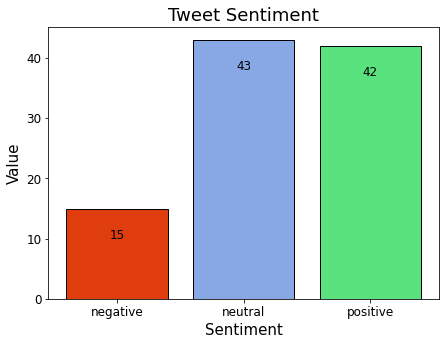

In [118]:
st = df.groupby(['sentimen_textblob']).sum()
st.reset_index(inplace = True)
plot_bar(st['sentimen_textblob'], st['value'])

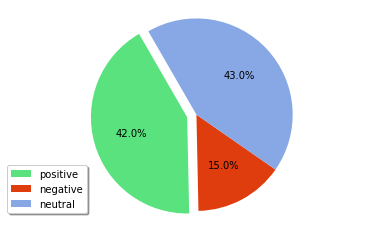

In [120]:
explode=(0.1,0,0)
labels = 'positive', 'negative','neutral'
sizes=(pos,neg,net)
colors=('#5AE27F','#DF3D0E','#88A8E5')

plt.pie(sizes,explode=explode,colors=colors,autopct='%1.1f%%',startangle=120)
plt.legend(labels,loc=(-0.05,0.05),shadow=True)
plt.axis('equal')
plt.savefig("Sentiment_Analysis TextBlob.png")

## **Modeling with Vader**

### Process

In [121]:
sid = SentimentIntensityAnalyzer()

In [122]:
df['scores'] = df['clean_english'].apply(lambda new_text: sid.polarity_scores(new_text))
df.head()

,content,value,clean_english,label,polarity,sentimen_textblob,scores
0,@kyuhee___ Pake masker dong.,1,Use a mask,neutral,0.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Gw bela2in pake double masker tp masih aja ada...,1,I use a double mask but just what gapake mask ...,positive,0.250000,positive,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp..."
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,1,Personnel Bhabinkamtibmas Baturiti Village Pol...,positive,0.400000,positive,"{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'comp..."
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",1,Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...,positive,0.134286,positive,"{'neg': 0.0, 'neu': 0.855, 'pos': 0.145, 'comp..."
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",1,"Sis Arif Stay Safe, if you don't forget to use...",positive,0.500000,positive,"{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp..."


In [123]:
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentimen_vader']=''
df.loc[df.compound>0,'sentimen_vader']='positive'
df.loc[df.compound==0,'sentimen_vader']='neutral'
df.loc[df.compound<0,'sentimen_vader']='negative'

In [124]:
df.head()

,content,value,clean_english,label,polarity,sentimen_textblob,scores,compound,sentimen_vader
0,@kyuhee___ Pake masker dong.,1,Use a mask,neutral,0.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,Gw bela2in pake double masker tp masih aja ada...,1,I use a double mask but just what gapake mask ...,positive,0.250000,positive,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.5499,positive
2,Personil Bhabinkamtibmas Desa Baturiti Polsek ...,1,Personnel Bhabinkamtibmas Baturiti Village Pol...,positive,0.400000,positive,"{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'comp...",0.5267,positive
3,"Itu baru planning ke dpn, coba lu baca\n\nSkrg...",1,Planning Dpn Try Lu Bacaskrg Singapore Sdg Nar...,positive,0.134286,positive,"{'neg': 0.0, 'neu': 0.855, 'pos': 0.145, 'comp...",0.6249,positive
4,"@rahasiarif kak arif juga stay safe yah, kalo ...",1,"Sis Arif Stay Safe, if you don't forget to use...",positive,0.500000,positive,"{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...",0.5523,positive


In [125]:
positive=df[df['sentimen_vader']=="positive"]
print("Positive\t: "+str(positive.shape[0]/(df.shape[0])*100)+"%")
pos=positive.shape[0]/df.shape[0]*100

negative=df[df['sentimen_vader']=="negative"]
print("Negative\t: "+str(negative.shape[0]/(df.shape[0])*100)+"%")
neg=negative.shape[0]/df.shape[0]*100

neutral=df[df['sentimen_vader']=="neutral"]
print("Neutral\t\t: "+str(neutral.shape[0]/(df.shape[0])*100)+"%")
net=neutral.shape[0]/df.shape[0]*100

Positive	: 45.0%
Negative	: 20.0%
Neutral		: 35.0%


### Result

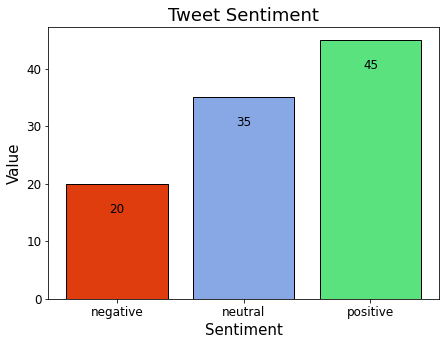

In [126]:
st = df.groupby(['sentimen_vader']).sum()
st.reset_index(inplace = True)
plot_bar(st['sentimen_vader'], st['value'])

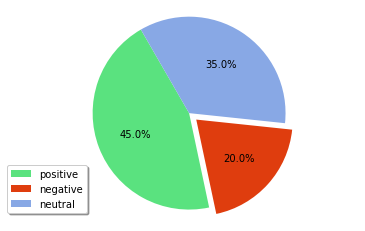

In [128]:
explode=(0,0.1,0)
labels = 'positive', 'negative','neutral'
sizes=(pos,neg,net)
colors=('#5AE27F','#DF3D0E','#88A8E5')

plt.pie(sizes,explode=explode,colors=colors,autopct='%1.1f%%',startangle=120)
plt.legend(labels,loc=(-0.05,0.05),shadow=True)
plt.axis('equal')
plt.savefig("Sentiment_Analysis Vader.png")

In [129]:
df.to_csv('/content/drive/MyDrive/final-project/hasil.csv', index=None)

## **Accuracy**

In [206]:
accuracy_score(df['label'],df['sentimen_textblob'])

0.74

In [ ]:
print(classification_report(df['label'],df['sentimen_textblob']))

              precision    recall  f1-score   support

    negative       0.53      0.57      0.55        14
     neutral       0.70      0.83      0.76        36
    positive       0.86      0.72      0.78        50

    accuracy                           0.74       100
   macro avg       0.70      0.71      0.70       100
weighted avg       0.75      0.74      0.74       100



In [ ]:
#Confusion Matrix Testing
cm_pred = confusion_matrix(df['label'],df['sentimen_textblob'])
print(cm_pred)

[[ 8  4  2]
 [ 2 30  4]
 [ 5  9 36]]


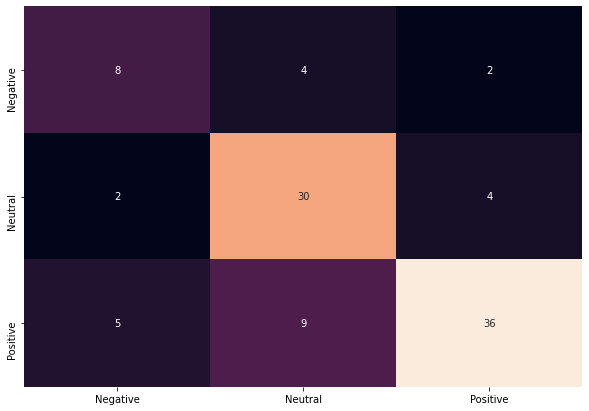

In [ ]:
df_cm_pred = pd.DataFrame(cm_pred, index = [i for i in ["Negative", "Neutral", "Positive"]],
                          columns = [i for i in ["Negative", "Neutral", "Positive"]])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm_pred, annot=True, cbar=False, fmt="d")
plt.savefig('/content/drive/MyDrive/final-project/confusion_matrix_textblob.jpg')

In [ ]:
accuracy_score(df['label'],df['sentimen_vader'])

0.79

In [ ]:
print(classification_report(df['label'],df['sentimen_vader']))

              precision    recall  f1-score   support

    negative       0.50      0.71      0.59        14
     neutral       0.83      0.81      0.82        36
    positive       0.89      0.80      0.84        50

    accuracy                           0.79       100
   macro avg       0.74      0.77      0.75       100
weighted avg       0.81      0.79      0.80       100



In [ ]:
#Confusion Matrix Testing
cm_pred = confusion_matrix(df['label'],df['sentimen_vader'])
print(cm_pred)

[[10  2  2]
 [ 4 29  3]
 [ 6  4 40]]


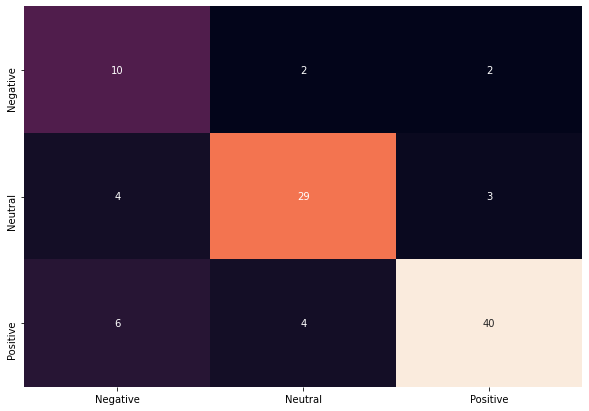

In [ ]:
df_cm_pred = pd.DataFrame(cm_pred, index = [i for i in ["Negative", "Neutral", "Positive"]],
                          columns = [i for i in ["Negative", "Neutral", "Positive"]])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm_pred, annot=True, cbar=False, fmt="d")
plt.savefig('/content/drive/MyDrive/final-project/confusion_matrix_vader.jpg')

## **Analysis**

In [138]:
new_df = pd.DataFrame(df['label'])
new_df.insert(1, 'metodh', 'manual')

In [139]:
vals = df.values

In [ ]:
vals.tolist()

In [141]:
a = df['sentimen_textblob']
for i in a:
  new_df.loc[len(new_df)] = [i, 'textblob']

a = df['sentimen_vader']
for i in a:
  new_df.loc[len(new_df)] = [i, 'vader']

In [142]:
new_df
new_df.insert(1, 'value', '1')

In [198]:
convert_dict = {'value': int}
new_df = new_df.astype(convert_dict)
new_df

,label,value,metodh
0,neutral,1,manual
1,positive,1,manual
2,positive,1,manual
3,positive,1,manual
4,positive,1,manual
...,...,...,...
295,negative,1,vader
296,positive,1,vader
297,neutral,1,vader
298,negative,1,vader


In [199]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   300 non-null    object
 1   value   300 non-null    int64 
 2   metodh  300 non-null    object
dtypes: int64(1), object(2)
memory usage: 19.4+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


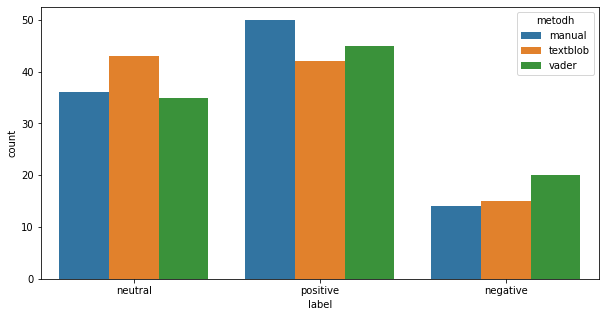

In [205]:
import seaborn as sns
fig1, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(new_df['label'],hue=new_df['metodh'])

In [197]:
ss = new_df.groupby(['label','metodh']).sum()
ss.reset_index(inplace = True)
ss

,label,metodh,value
0,negative,manual,14
1,negative,textblob,15
2,negative,vader,20
3,neutral,manual,36
4,neutral,textblob,43
5,neutral,vader,35
6,positive,manual,50
7,positive,textblob,42
8,positive,vader,45
